In [1]:
from tqdm import tqdm
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
import time
import threading
from queue import Queue

In [2]:
def plot_grid(N, matrix):
    """A method for plotting the actions"""
    # Create a colormap for 'A' and 'B'
    colors = {'A': 'lightblue', 'B': 'lightgreen'}

    # Create a grid of the same size as the matrix and initialize it with white
    colored_grid = [['white' for _ in range(N)] for _ in range(N)]

    # Fill the grid with colors based on the values in the matrix
    for i in range(N):
        for j in range(N):
            cell_value = matrix[i][j]
            if cell_value in colors:
                colored_grid[i][j] = colors[cell_value]

    # Create the plot
    fig, ax = plt.subplots(figsize=(N/3, N/3))

    # Create a table to represent the grid with colored cells
    table = plt.table(cellText=matrix, cellColours=colored_grid, loc='center')

    # Remove the axes and labels
    ax.axis('off')
    ax.set_title(f"{N}x{N}")

    # Display the plot
    plt.show()

In [21]:
class Env:
    def __init__(self, grid_size=2, num_strategy=2, seed=42, verbose=True):
        self.seed = seed
        np.random.seed(self.seed)
        random.seed(self.seed)
        self.grid_size = grid_size
        self.num_strategy = num_strategy
        self.action_space = {'A', 'B'}
        self.verbose = verbose
        self.payoffs = {'AA': (1, 1), 'AB': (-1, -1), 'BA': (-1, -1), 'BB': (1, 1)}

    def transition_rl(self, agent_state, opp_state, actions):
        """Return the rewards for a given state and action pair in the reinforcement learning adaptation"""
        i, j = agent_state[0], agent_state[1]
        i_o, j_o = opp_state[0], opp_state[1]
        # extract action for agent and opponent
        agent_action = actions[i][j]
        opp_action =  actions[i_o][j_o]
        # extract payoffs
        reward = self.payoffs[agent_action + opp_action]
        if self.verbose: print(f"self.payoffs[{agent_action} + {opp_action}]")
        # assign rewards for each agent
        reward_agent, reward_opp = reward[0], reward[1]

        return reward_agent, reward_opp

    def transition_fp(self, agent_state, opp_state, action_proba, pay_history):
        """Return the best response of the agent for the fictitious play adaptation"""
        # positions of agent and opponent
        i, j = agent_state[0], agent_state[1]
        i_o, j_o = opp_state[0], opp_state[1]
        # inputs for computing the best response
        opp_prob_A = action_proba[0][i_o][j_o]   # probability of opponent playing A
        opp_prob_B = action_proba[1][i_o][j_o]   # probability of opponent playing B
        if self.verbose: print("opp_prob_A/B: ", opp_prob_A, opp_prob_B)
        #agent_payoff_AA = self.payoffs['AA'][0]  # agent payoff for playing A when the opponent plays A
        #agent_payoff_AB = self.payoffs['AB'][0]  # agent payoff for playing A when the opponent plays B
        #agent_payoff_BA = self.payoffs['BA'][0]  # agent payoff for playing B when the opponent plays A
        #agent_payoff_BB = self.payoffs['BB'][0]  # agent payoff for playing B when the opponent plays B

        agent_payoff_AA = pay_history[0][i][j] + pay_history[0][i_o][j_o] # total payoffs of agents playing AA
        agent_payoff_AB = pay_history[0][i][j] + pay_history[1][i_o][j_o] # total payoffs of agents playing AB
        agent_payoff_BA = pay_history[1][i][j] + pay_history[0][i_o][j_o] # total payoffs of agents playing BA
        agent_payoff_BB = pay_history[1][i][j] + pay_history[1][i_o][j_o] # total payoffs of agents playing BB

        # utility of playing action A and B for the agent
        utility_agent_A = opp_prob_A*agent_payoff_AA + opp_prob_B*agent_payoff_AB
        utility_agent_B = opp_prob_A*agent_payoff_BA + opp_prob_B*agent_payoff_BB
        if self.verbose: print("probbaility_A/B: ", opp_prob_A, opp_prob_B)
        if self.verbose: print("utility_agent_A/B: ", utility_agent_A, utility_agent_B)
        # agent's best response
        agent_br = np.random.choice([0, 1]) if utility_agent_A==utility_agent_B else np.argmax([utility_agent_A, utility_agent_B])

        return agent_br

class coordinate(Env):
    def __init__(self, Env, learning_rate=0.1, gamma=0.9):
        self.Env = Env
        #np.random.seed(self.Env.seed)
        #random.seed(self.Env.seed)
        self.actions = np.array([[random.choice(["A", "B"]) for _ in range(self.Env.grid_size)] for _ in range(self.Env.grid_size)])
        self.action_cnt = np.zeros([self.Env.num_strategy, self.Env.grid_size, self.Env.grid_size])
        self.pay_history = np.zeros([self.Env.num_strategy, self.Env.grid_size, self.Env.grid_size])
        self.Q_a = np.full_like(self.action_cnt, 0)
        self.verbose = self.Env.verbose
        self.action_space_map = {'A':0, 'B':1}
        self.action_space_map_rev = {0:'A', 1: 'B'}
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.agent_action_ = None
        self.opp_action_ = None
        self.pay_avg_history = None
        self.agent_matrix = self.padded_matrix(N=self.Env.grid_size)
        if self.verbose: print("\nself.agent_matrix:\n", self.agent_matrix)
        self.proba = None

    def padded_matrix(self, N):
        """Create a matrix consisting of N*N agents and padded opponents along the edges (warped world)"""
        # create a padded matrix with zeros
        padded_matrix = np.zeros((N + 2, N + 2), dtype=int)

        # create a filled padded matrix as described
        for i in range(1, N + 1):
            for j in range(1, N + 1):
                padded_matrix[i, j] = (i - 1) % N * N + j

        # fill the top row with values from the inner bottom row
        padded_matrix[0, 1:-1] = padded_matrix[N, 1:-1]

        # fill the bottom row with values from the inner top row
        padded_matrix[N + 1, 1:-1] = padded_matrix[1, 1:-1]

        # fill the left column with values from the inner right column
        padded_matrix[1:-1, 0] = padded_matrix[1:-1, N]

        # fill the right column with values from the inner left column
        padded_matrix[1:-1, N + 1] = padded_matrix[1:-1, 1]

        # fill upper left corner with inner lower right corner
        padded_matrix[0, 0] = padded_matrix[N, N]

        # fill upper right corner with inner lower left corner
        padded_matrix[0, N+1] = padded_matrix[N, 1]

        # fill lower left corner with inner upper right corner
        padded_matrix[N+1, 0] = padded_matrix[1, N]

        # fill lower right corner with inner upper left corner
        padded_matrix[N+1, N+1] = padded_matrix[1, 1]

        return padded_matrix

    def opponent_position(self, matrix, opp_value, N):
        """Determine the index in the inner array for an opponent from the padded edges based on the value chosen"""
        # inner matrix with agents of interest
        inner_array = matrix[1:N+1, 1:N+1]
        # find the indices of the value within the inner array
        indices = np.where(inner_array == opp_value)
        # index of the edge value in the inner matrix
        opp_inner_index = [indices[0][0], indices[1][0]]

        return opp_inner_index

    def learn_rl(self):
        """Apply learning processes in the reinforcement learning adaptation to update the action value function"""
        for i in range(self.Env.grid_size):
            for j in range(self.Env.grid_size):
                #i, j = np.random.choice(np.arange(0, self.Env.grid_size)), np.random.choice(np.arange(0, self.Env.grid_size))
                if self.verbose: print("\ni,j:", i,j)
                # initialize state
                agent_index = [i, j]
                # index of neighbouring agents
                index = np.array([[i, j], [i, j+1], [i, j+2], [i+1, j], [i+1, j+2], [i+2, j], [i+2, j+1], [i+2, j+2]])
                # randomly choose a neighbouring opponent
                opp_outer_index = random.choice(index)
                if self.verbose: print("opp_outer_index: \n", opp_outer_index)
                # find the opponent's inner matrix index
                opp_inner_index = self.opponent_position(matrix=self.agent_matrix, opp_value=self.agent_matrix[opp_outer_index[0]][opp_outer_index[1]], N=self.Env.grid_size)
                if self.verbose: print("opp_inner_index: \n", opp_inner_index)
                # position of opponent
                i_o, j_o = opp_inner_index[0], opp_inner_index[1]

                # check whether there are any q values by strategy for the agent and opponent
                agent_cnt_zero = self.action_cnt[0][i][j] == 0 and self.action_cnt[1][i][j] == 0
                opp_cnt_zero = self.action_cnt[0][i_o][j_o] == 0 and self.action_cnt[1][i_o][j_o] == 0
                # extract Q values of the agent and opponent for the current state
                Q_a_valA_agent = self.Q_a[0][i][j]
                Q_a_valB_agent = self.Q_a[1][i][j]
                Q_a_valA_opp = self.Q_a[0][i_o][j_o]
                Q_a_valB_opp = self.Q_a[1][i_o][j_o]

                # if there's no defined Q values for either the agent or opponent
                if agent_cnt_zero or opp_cnt_zero:
                    # if there's 0 initialized Q values defined for the agent, randomly choose a strategy
                    if agent_cnt_zero:
                        agent_action = np.random.choice([0,1])
                    else:
                        # if there's a tie in Q values for the agent, randomly choose a strategy
                        if Q_a_valA_agent == Q_a_valB_agent:
                            agent_action = np.random.choice([0, 1])
                        else:
                            # otherwise choose the strategy that provides a higher Q value
                            agent_action = np.argmax(np.array([Q_a_valA_agent, Q_a_valB_agent]))
                    # if there's 0 initialized Q values defined for the opponent, randomly choose a strategy
                    if opp_cnt_zero:
                        opp_action = np.random.choice([0,1])
                    else:
                          # if there's a tie in Q values for the opponent, randomly choose a strategy
                        if Q_a_valA_opp == Q_a_valB_opp:
                            opp_action = np.random.choice([0, 1])
                        else:
                            # otherwise choose the strategy that provides a higher Q value
                            opp_action = np.argmax(np.array([Q_a_valA_opp, Q_a_valB_opp]))
                else:
                    # if there are non pre-initialized 0 Q values and the Q values are equal for both strategies, randomly choose one
                    if Q_a_valA_agent == Q_a_valB_agent:
                        agent_action = np.random.choice([0, 1])
                    else:
                        # otherwise choose the strategy that provides a higher value
                        agent_action = np.argmax(np.array([Q_a_valA_agent, Q_a_valB_agent]))
                    # similarly done for the opponent
                    if Q_a_valA_opp == Q_a_valB_opp:
                        opp_action = np.random.choice([0, 1])
                    else:
                        opp_action = np.argmax(np.array([Q_a_valA_opp, Q_a_valB_opp]))

                if self.verbose: print(f"\nagent actions before:\n {self.actions[i][j]}")
                # agent and opponent actions
                self.agent_action_ = self.action_space_map_rev[agent_action]
                self.opp_action_ = self.action_space_map_rev[opp_action]
                if self.verbose: print("\nagent/opp positions:\n", agent_index, opp_inner_index)

                # update action table
                if self.verbose: print("\nbefore updating actions:\n", self.actions)
                self.actions[i][j] = self.agent_action_
                if self.verbose: print("\nafter updating actions:\n", self.actions)
                if self.verbose: print("\nagent actions after:\n", self.agent_action_)
                ##self.actions[i_o][j_o] = self.opp_action_

                # extract rewards, actions, and index of opponent
                reward_agent, reward_opp = self.Env.transition_rl(agent_state=agent_index, opp_state=opp_inner_index, actions=self.actions)
                if self.verbose: print("\nreward agent:\n", reward_agent)

                # update action counts
                if self.verbose: print("\nbefore updating action_cnt:\n", self.action_cnt)
                self.action_cnt[agent_action][i][j] += 1
                if self.verbose: print("\nafter updating action_cnt:\n", self.action_cnt)
                ##self.action_cnt[opp_action][i_o][j_o] += 1

                # optimal future Q values for agent and opponent
                Q_opt_future_agent = max(self.Q_a[0][i][j], self.Q_a[1][i][j])
                ##Q_opt_future_opp = max(self.Q_a[0][i_o][j_o], self.Q_a[1][i_o][j_o])

                if self.verbose: print("\nbefore updating Q_a:\n", self.Q_a)
                # update Q table
                self.Q_a[agent_action][i][j] = (1-self.learning_rate) * self.Q_a[agent_action][i][j] + \
                    self.learning_rate * (reward_agent + self.gamma * Q_opt_future_agent)
                if self.verbose: print("\nafter updating Q_a:\n", self.Q_a)

                ##self.Q_a[opp_action][i_o][j_o] = \
                ##    (1-self.learning_rate)*self.Q_a[opp_action][i_o][j_o] + \
                ##    self.learning_rate * (reward_opp + self.gamma * Q_opt_future_opp)

    def learn_fp(self):
        """Apply learning processes in the fictitious play adaptation to update the actions based on best response"""
        for i in range(self.Env.grid_size):
            for j in range(self.Env.grid_size):
                #i, j = np.random.choice(np.arange(0, self.Env.grid_size)), np.random.choice(np.arange(0, self.Env.grid_size))
                # agent's position
                agent_index = [i, j]
                # index of neighbouring agents
                index = np.array([[i, j], [i, j+1], [i, j+2], [i+1, j], [i+1, j+2], [i+2, j], [i+2, j+1], [i+2, j+2]])

                # randomly choose a neighbouring opponent
                opp_outer_index = random.choice(index)
                if self.verbose: print("\nopp_outer_index: \n", opp_outer_index)
                # find the opponent's inner matrix index
                opp_inner_index = self.opponent_position(matrix=self.agent_matrix, opp_value=self.agent_matrix[opp_outer_index[0]][opp_outer_index[1]], N=self.Env.grid_size)
                if self.verbose: print("\nopp_inner_index: \n", opp_inner_index)
                # position of opponent
                i_o, j_o = opp_inner_index[0], opp_inner_index[1]

                # agent and opponent actions
                self.agent_action = self.actions[i][j]
                self.opp_action = self.actions[i_o][j_o]
                if self.verbose: print(f"\nagent action:\n {self.agent_action}")
                if self.verbose: print(f"\nopp action:\n {self.opp_action}")
                if self.verbose: print("\nagent/opp positions:\n", agent_index, opp_inner_index)

                # agent and opponent payoffs
                agent_pay, opp_pay = self.Env.payoffs[self.agent_action + self.opp_action][0], self.Env.payoffs[self.agent_action + self.opp_action][1]
                # update the pay history
                if self.verbose: print("\nbefore updating pay_history:\n", self.pay_history)
                self.pay_history[self.action_space_map[self.agent_action]][i][j] += agent_pay
                #self.pay_history[self.action_space_map[self.opp_action]][i_o][j_o] += opp_pay
                if self.verbose: print("\nafter updating pay_history:\n", self.pay_history)

                # update action counts
                if self.verbose: print("\nbefore updating action_cnt:\n", self.action_cnt)
                self.action_cnt[self.action_space_map[self.agent_action]][i][j] += 1
                if self.verbose: print("\nafter updating action_cnt:\n", self.action_cnt)
                ##self.action_cnt[self.action_space_map[self.opp_action]][i_o][j_o] += 1

                # compute probability distributions
                self.action_proba = self.action_cnt / np.sum(self.action_cnt, axis=0)
                self.action_proba = np.nan_to_num(self.action_proba, nan=0.0)
                if self.verbose: print("\nafter action_proba:\n", self.action_proba)

                # get agent's best responses
                agent_br = self.Env.transition_fp(agent_state=agent_index, opp_state=opp_inner_index, action_proba=self.action_proba, pay_history=self.pay_history)
                if self.verbose: print("\nagent best response:\n", self.action_space_map_rev[agent_br])
                # update action matrix with best reponses
                if self.verbose: print("\nbefore updating actions:\n", self.actions)
                self.actions[i][j] = self.action_space_map_rev[agent_br]
                ##self.actions[i_o][j_o] = self.action_space_map_rev[opp_br]
                if self.verbose: print("\nafter updating actions:\n", self.actions)

    def run(self, learning_algorithm, n_iter=100, iter_limit=1000, bar_plot=False, line_plot=True, verbose=False):
        if learning_algorithm == 'rl': print("--------------Executing Reinforcement Learning Adaptation Process--------------\n\n")
        if learning_algorithm == 'fp': print("--------------Executing Fictitious Play Adaptation Process--------------\n")

        print("Actions (Randomly Initialized): \n")
        plot_grid(N=self.Env.grid_size, matrix=self.actions)

        cur_iter = 0
        frac_A = []
        no_change_count = 0 # counter for consecutive iterations with no change
        prev_A_cnt_ratio = None  # initialize with None
        total_time = 0
        n = 0

        #for _ in tqdm(range(n_iter)):
        for _ in range(n_iter):
            start_time = time.time()
            # list of actions
            flattened_list = [e for r in self.actions for e in r]
            # count of A and B actions
            A_cnt = Counter(flattened_list)['A']
            B_cnt = Counter(flattened_list)['B']
            # ratio of agents choosing action A
            A_cnt_ratio = A_cnt/(A_cnt+B_cnt)
            # store ratio
            frac_A.append(A_cnt_ratio)

            if bar_plot:
                # Visualization
                plt.close()
                values, counts = zip(*Counter(flattened_list).items())
                plt.bar(values, counts)
                plt.show()

            # Check if the actions have all converged to a single strategy or if the number of iterations has exceeded the set limit
            if (A_cnt != 0 and B_cnt != 0) and cur_iter < n_iter:
                assert learning_algorithm == 'rl' or learning_algorithm == 'fp'
                if learning_algorithm == 'rl': self.learn_rl()
                if learning_algorithm == 'fp': self.learn_fp()

                if verbose:
                    if cur_iter == (2**n) and cur_iter != n_iter:
                        print(f"\n---------------------------Episode ({cur_iter})---------------------------")
                        plot_grid(N=self.Env.grid_size, matrix=self.actions)
                        n += 1

                # Check if A_cnt_ratio has not changed for 10 consecutive iterations
                if prev_A_cnt_ratio is not None and A_cnt_ratio == prev_A_cnt_ratio:
                    no_change_count += 1
                    if no_change_count >= iter_limit:
                        print(f"Terminating Loop: no change after {no_change_count} iterations.")
                        break
                else:
                    no_change_count = 0

                prev_A_cnt_ratio = A_cnt_ratio
                end_time = time.time()
                total_time += end_time - start_time
                cur_iter += 1

            else:
                break

        print(f"\nFinal Actions - Episode ({cur_iter}):\n")
        plot_grid(N=self.Env.grid_size, matrix=self.actions)
        print("\n")

        if line_plot:
            plt.plot(frac_A)
            plt.xlabel('Iterations')
            plt.ylabel('Ratio of Action A')
            plt.title('Ratio of Agents Choosing Action A Over Iterations')
            plt.show()

        return A_cnt_ratio == 0 or A_cnt_ratio == 1

## 5x5 Grid

### Reinforcement Learning

--------------Executing Reinforcement Learning Adaptation Process--------------


Actions (Randomly Initialized): 



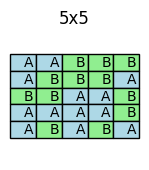


---------------------------Episode (1)---------------------------


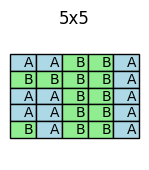


---------------------------Episode (2)---------------------------


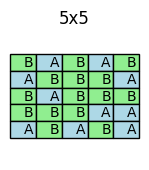


---------------------------Episode (4)---------------------------


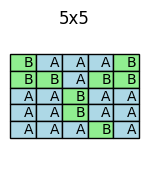


---------------------------Episode (8)---------------------------


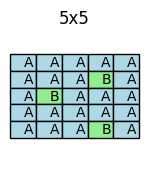


Final Actions - Episode (16):



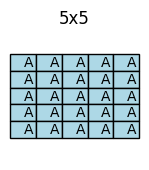

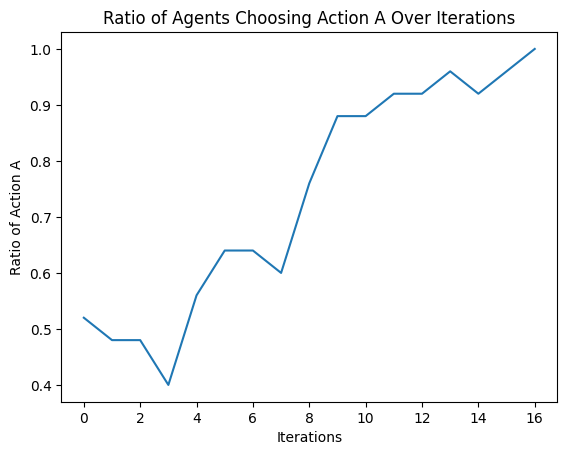

True

In [23]:
# Parameters: grid_size = N value, learning_algorithm = {'fp' = fictitious play, 'rl' = reinforcement learning}
# n_iter = number of episodes, iter_limit = terminate after no change experienced after iter_limit number of episodes

grid_env1 = Env(grid_size=5, seed=1854088, verbose=False)
c1 = coordinate(grid_env1, learning_rate=0.1, gamma=0.01)
c1.run(n_iter=1000, iter_limit=100, learning_algorithm='rl', verbose=True)

### Fictitious Play

--------------Executing Fictitious Play Adaptation Process--------------

Actions (Randomly Initialized): 



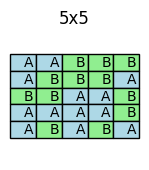

<ipython-input-21-516b51d72381>:265: RuntimeWarning: invalid value encountered in divide
  self.action_proba = self.action_cnt / np.sum(self.action_cnt, axis=0)



---------------------------Episode (1)---------------------------


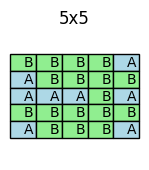


---------------------------Episode (2)---------------------------


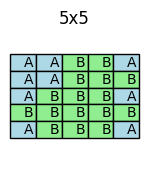


---------------------------Episode (4)---------------------------


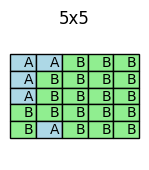


---------------------------Episode (8)---------------------------


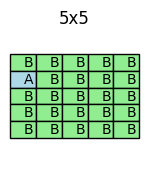


Final Actions - Episode (11):



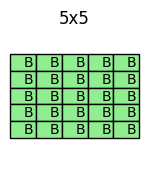

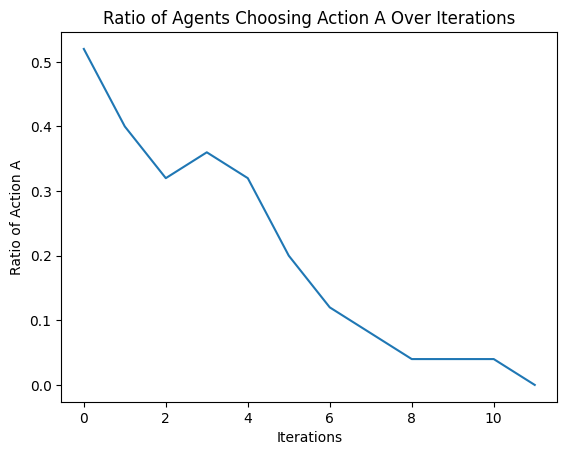

True

In [24]:
# Parameters: grid_size = N value, learning_algorithm = {'fp' = fictitious play, 'rl' = reinforcement learning}
# n_iter = number of episodes, iter_limit = terminate after no change experienced after iter_limit number of episodes

grid_env1 = Env(grid_size=5, seed=1854088, verbose=False)
c1 = coordinate(grid_env1)
c1.run(n_iter=1000, iter_limit=100, learning_algorithm='fp', verbose=True)

## 30x30 Grid

## Reinforcement Learning

--------------Executing Reinforcement Learning Adaptation Process--------------


Actions (Randomly Initialized): 



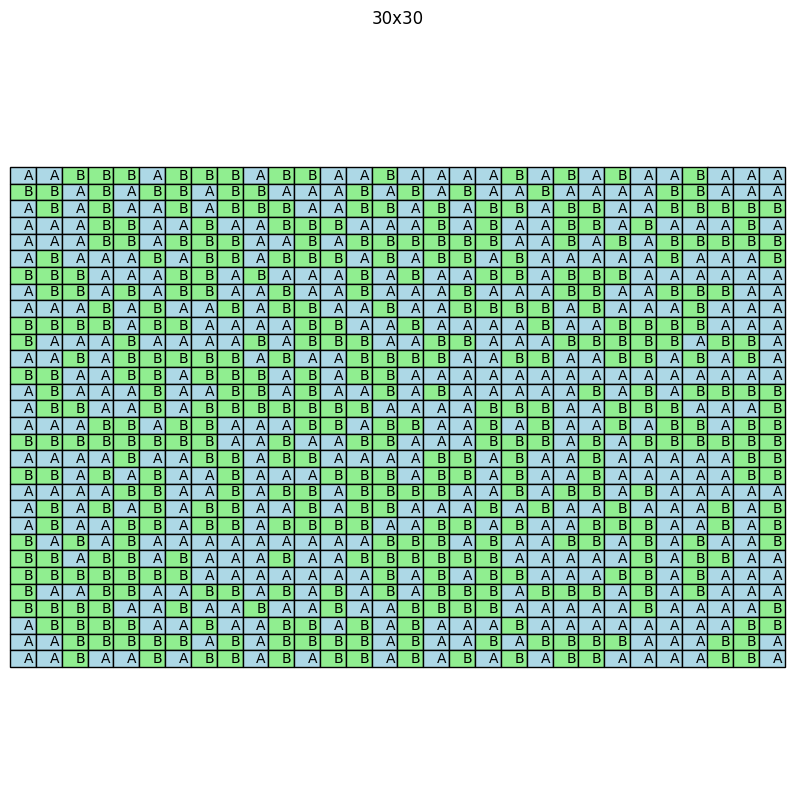


---------------------------Episode (1)---------------------------


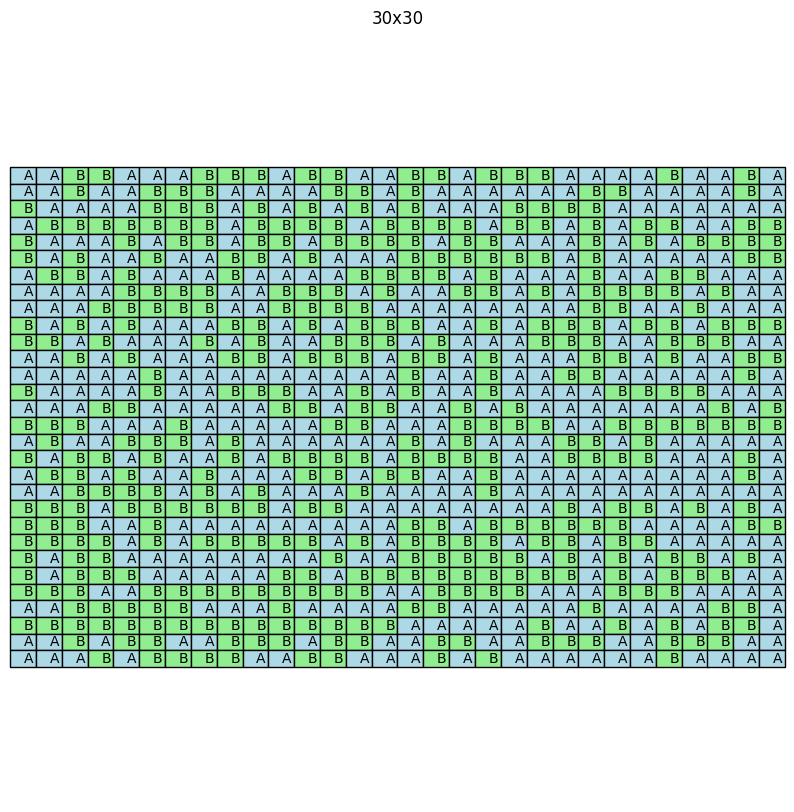


---------------------------Episode (2)---------------------------


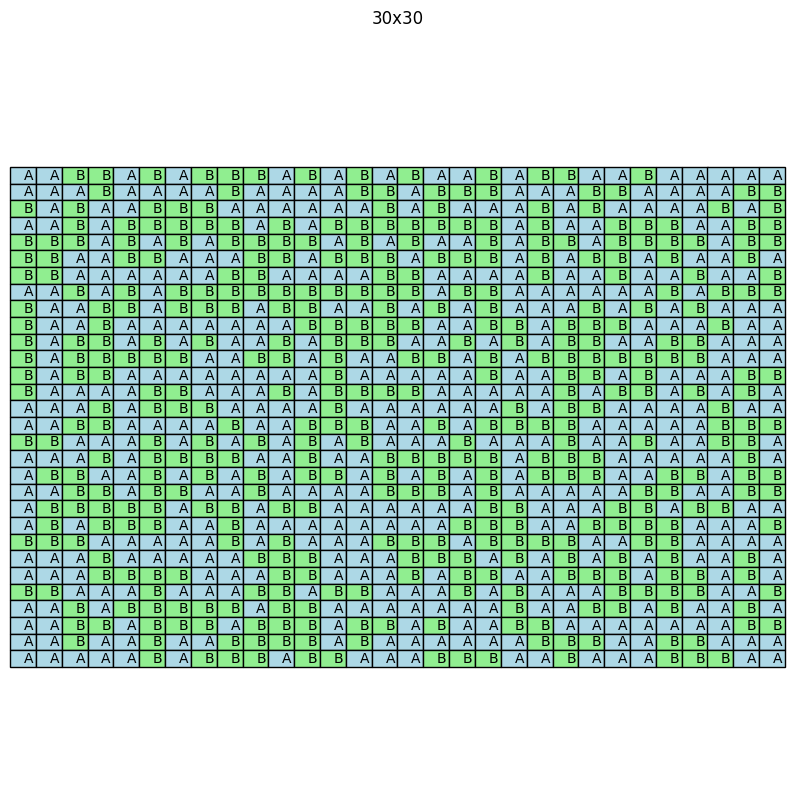


---------------------------Episode (4)---------------------------


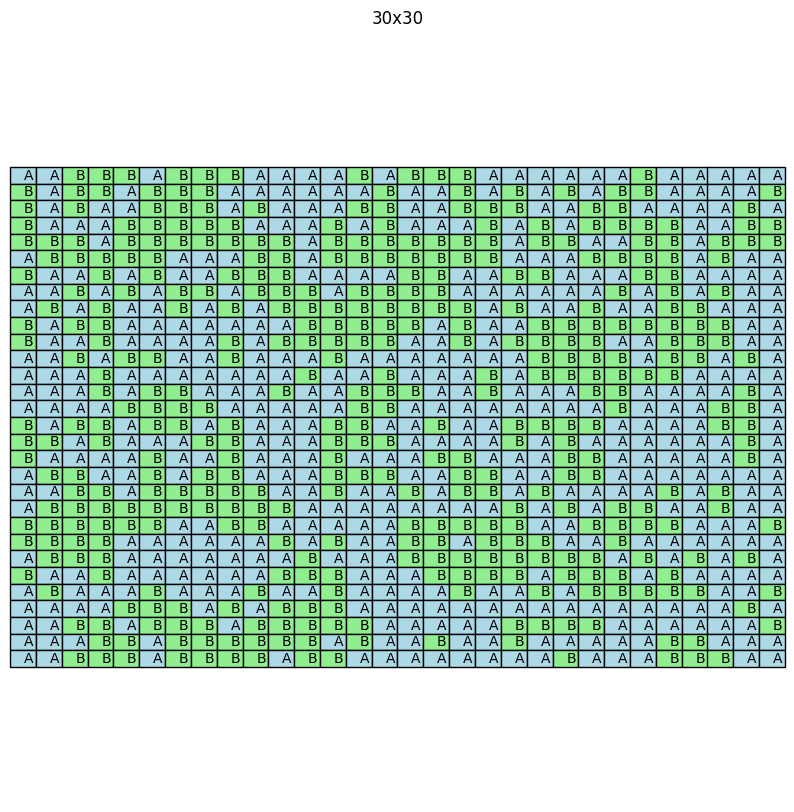


---------------------------Episode (8)---------------------------


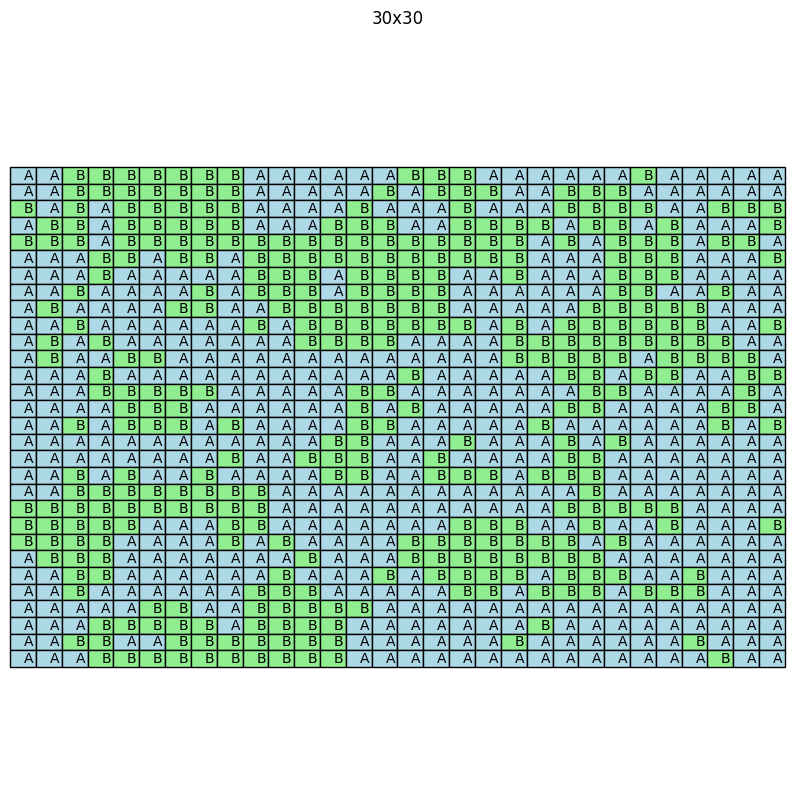


---------------------------Episode (16)---------------------------


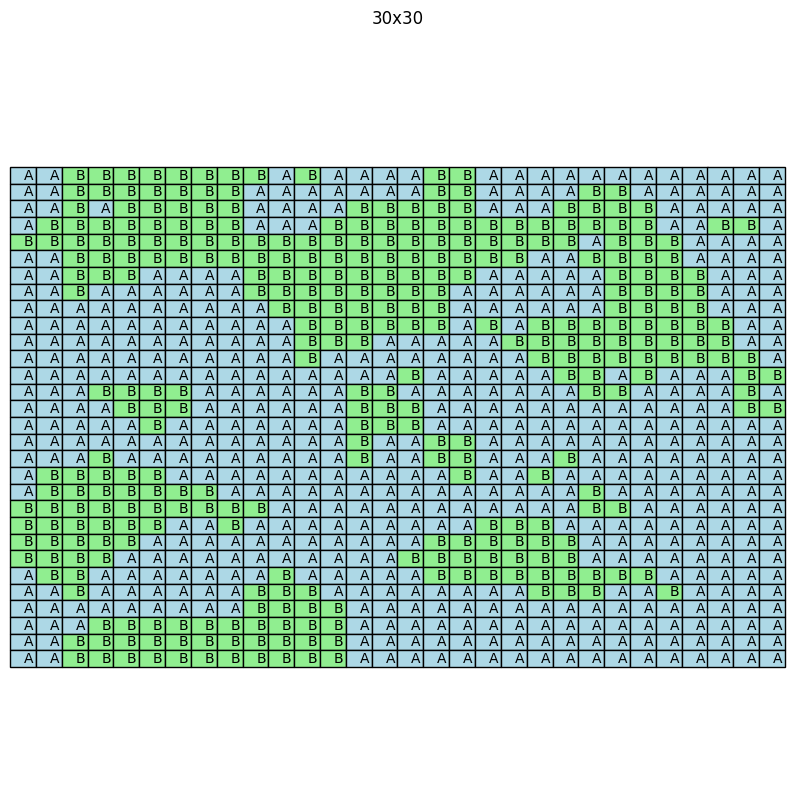


---------------------------Episode (32)---------------------------


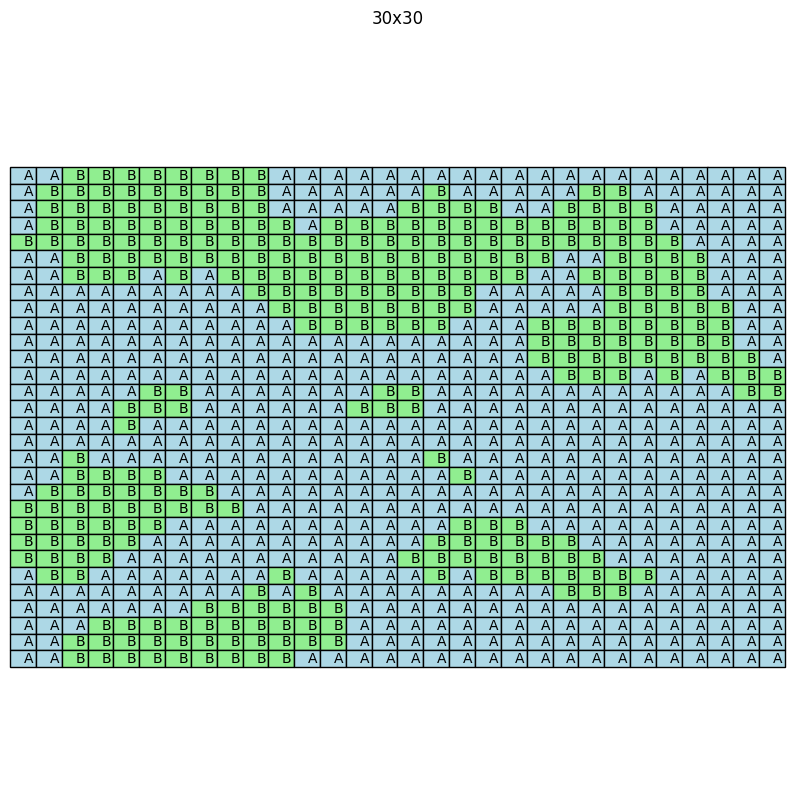


---------------------------Episode (64)---------------------------


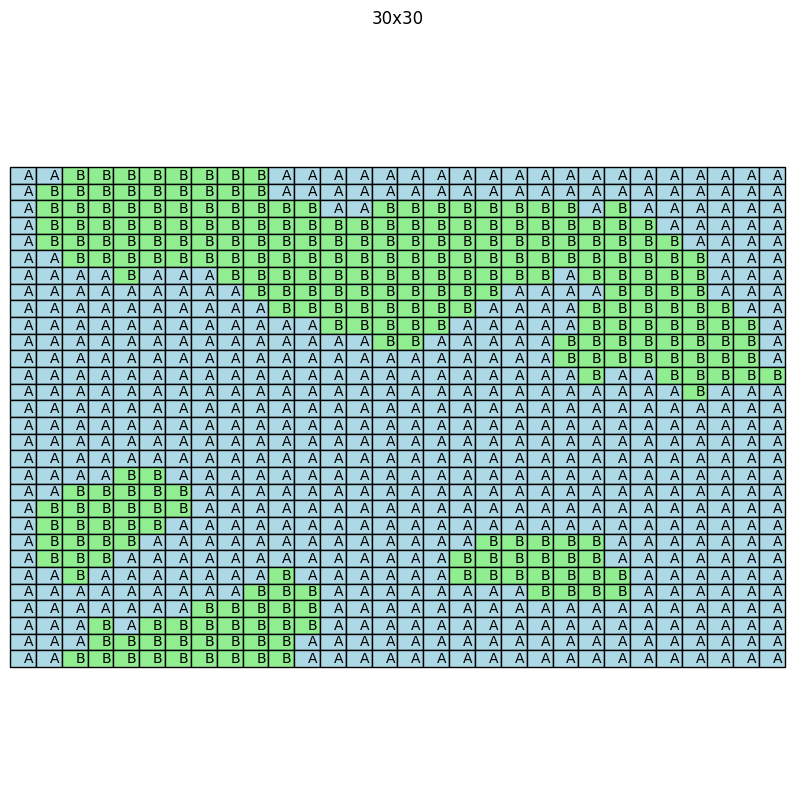


---------------------------Episode (128)---------------------------


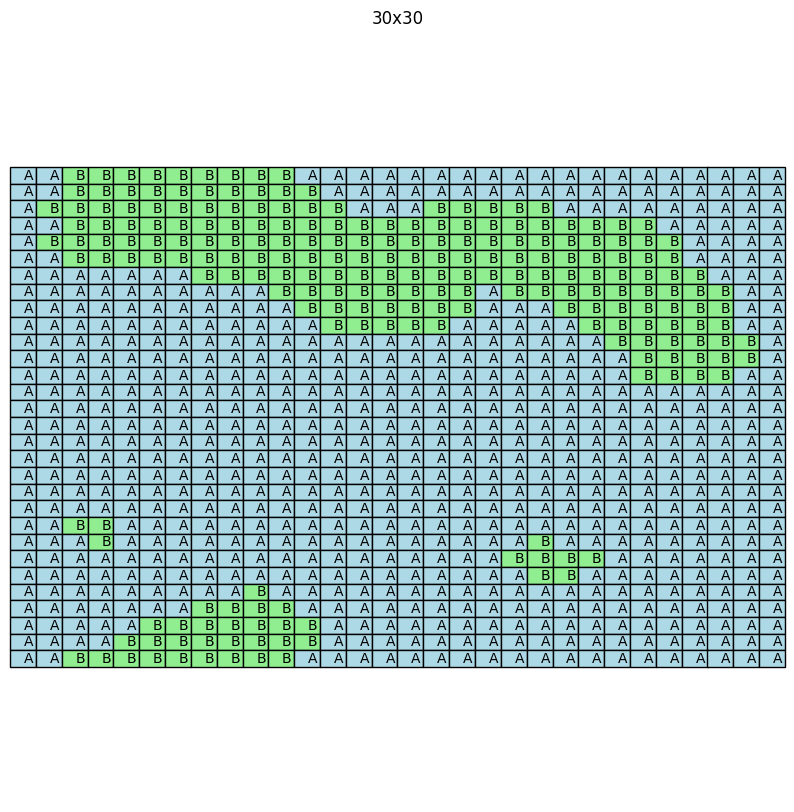


---------------------------Episode (256)---------------------------


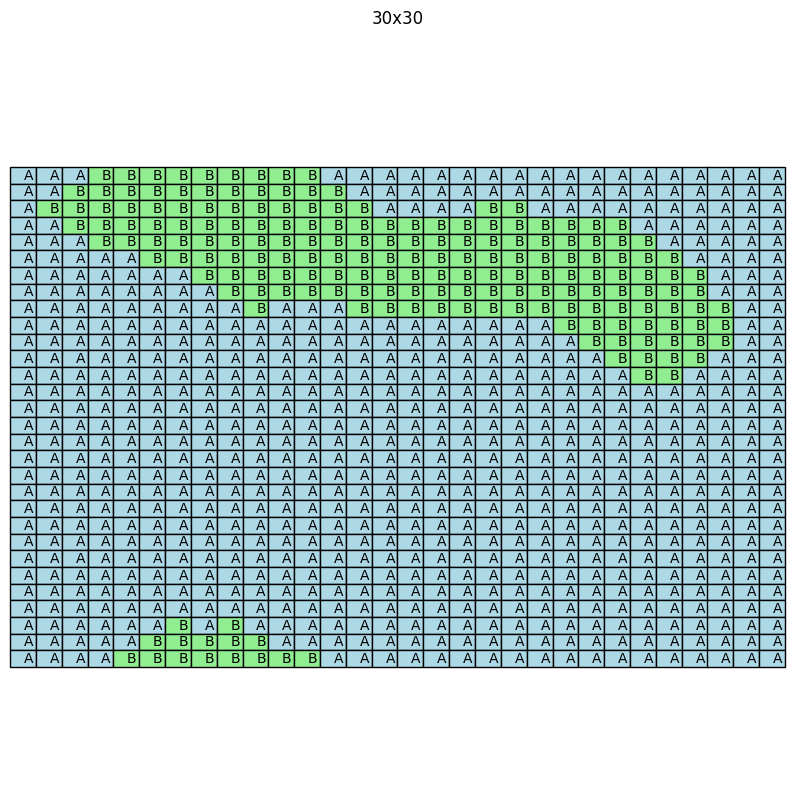


---------------------------Episode (512)---------------------------


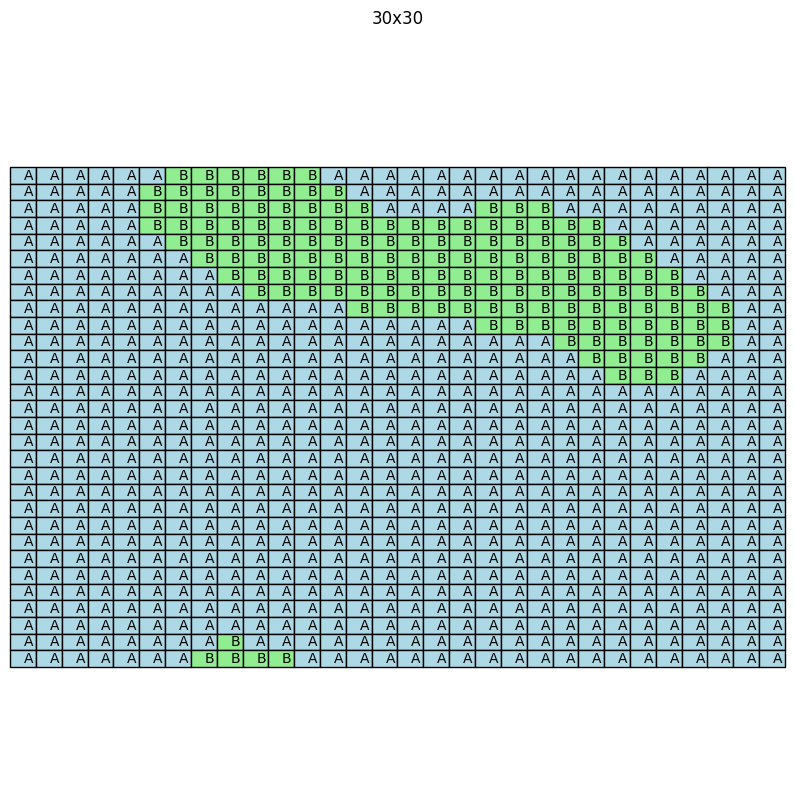


---------------------------Episode (1024)---------------------------


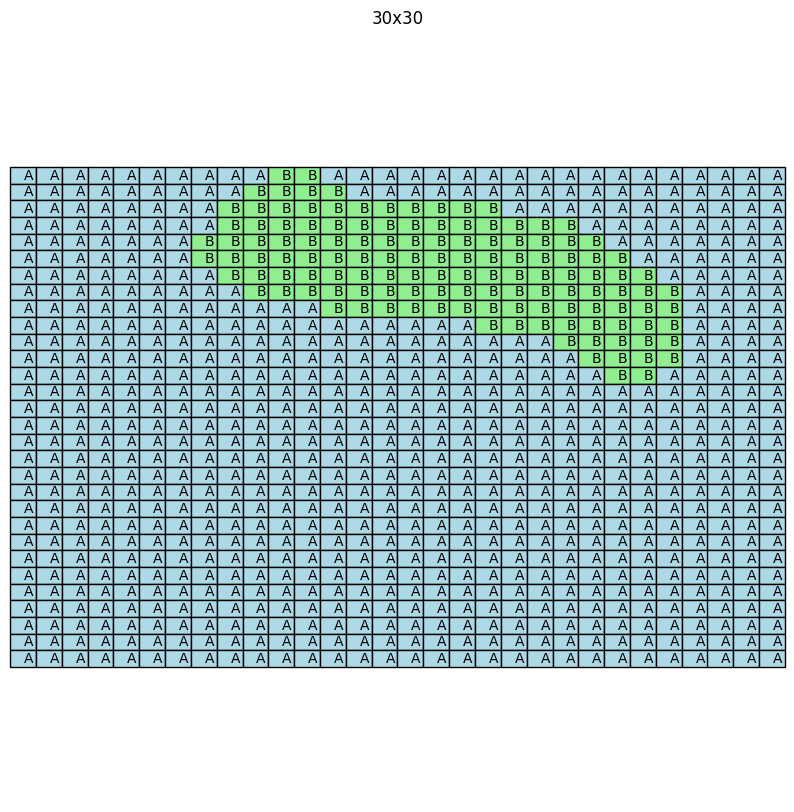


---------------------------Episode (2048)---------------------------


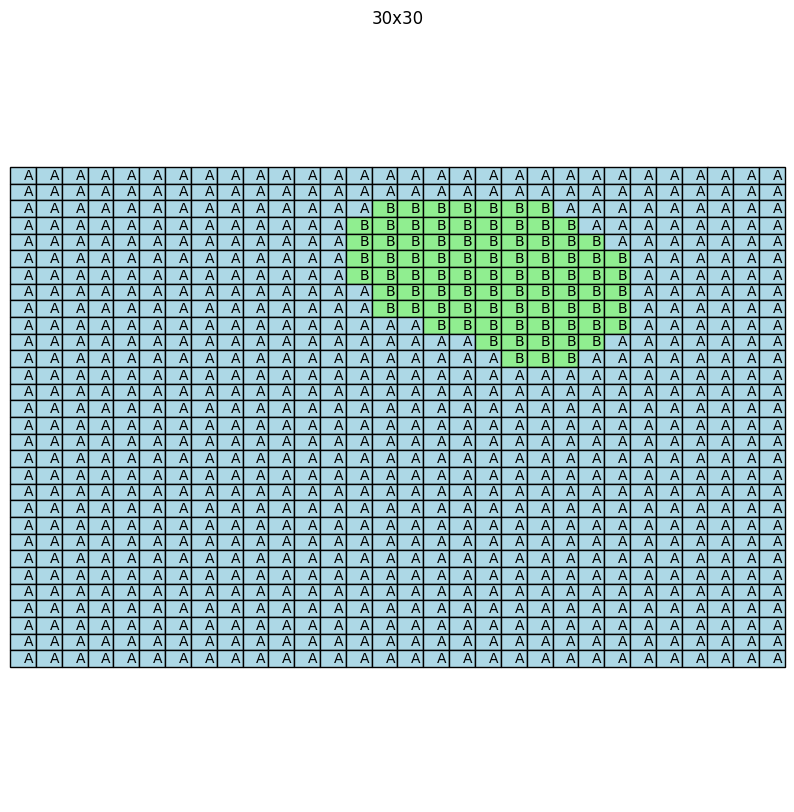


Final Actions - Episode (3739):



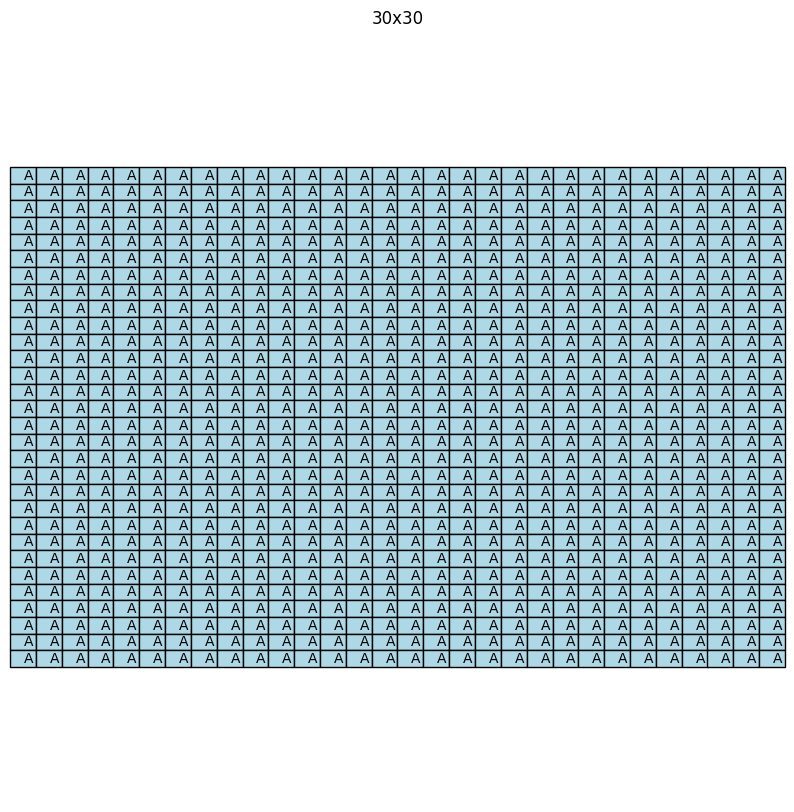

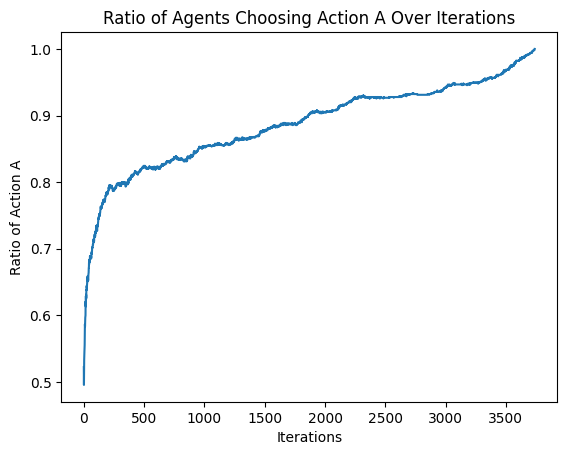

True

In [25]:
# Parameters: grid_size = N value, learning_algorithm = {'fp' = fictitious play, 'rl' = reinforcement learning}
# n_iter = number of episodes, iter_limit = terminate after no change experienced after iter_limit number of episodes

grid_env1 = Env(grid_size=30, seed=1854088, verbose=False)
c1 = coordinate(grid_env1, learning_rate=0.1, gamma=0.01)
c1.run(n_iter=10000, iter_limit=100, learning_algorithm='rl', verbose=True)

### Fictitious Play

--------------Executing Fictitious Play Adaptation Process--------------

Actions (Randomly Initialized): 



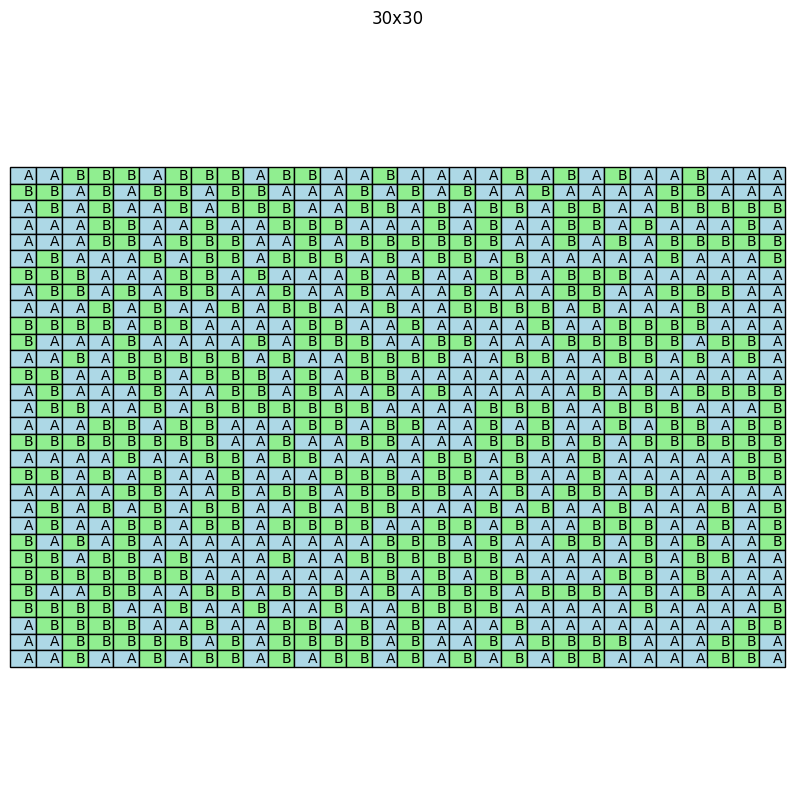

<ipython-input-21-516b51d72381>:265: RuntimeWarning: invalid value encountered in divide
  self.action_proba = self.action_cnt / np.sum(self.action_cnt, axis=0)



---------------------------Episode (1)---------------------------


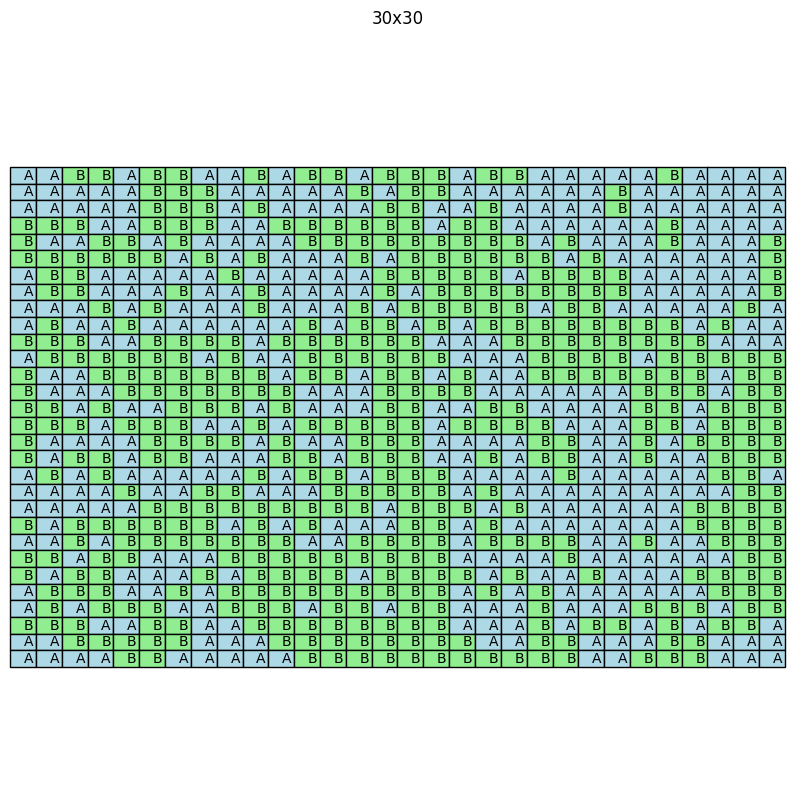


---------------------------Episode (2)---------------------------


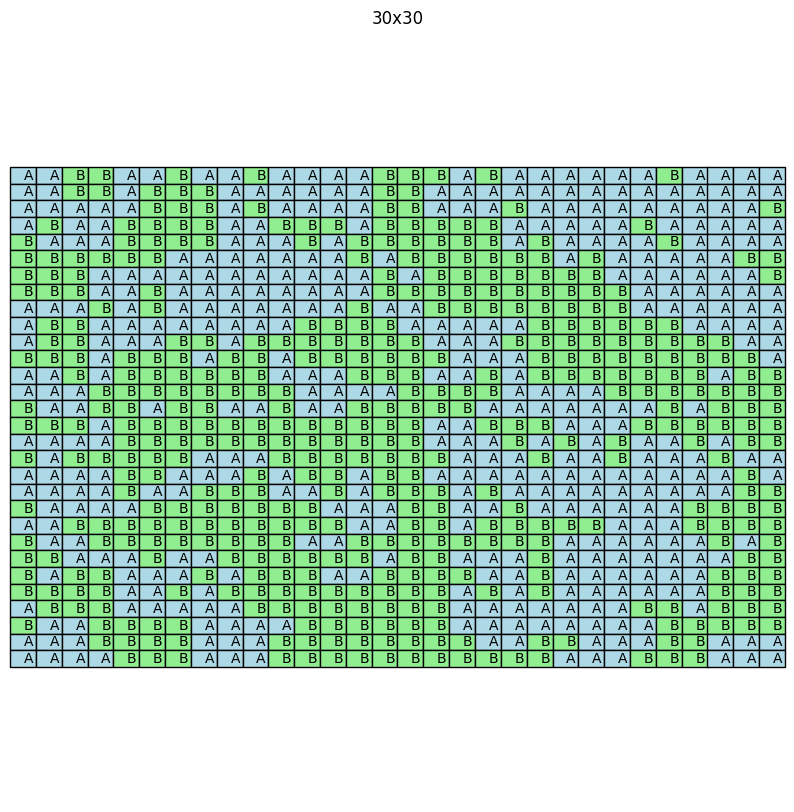


---------------------------Episode (4)---------------------------


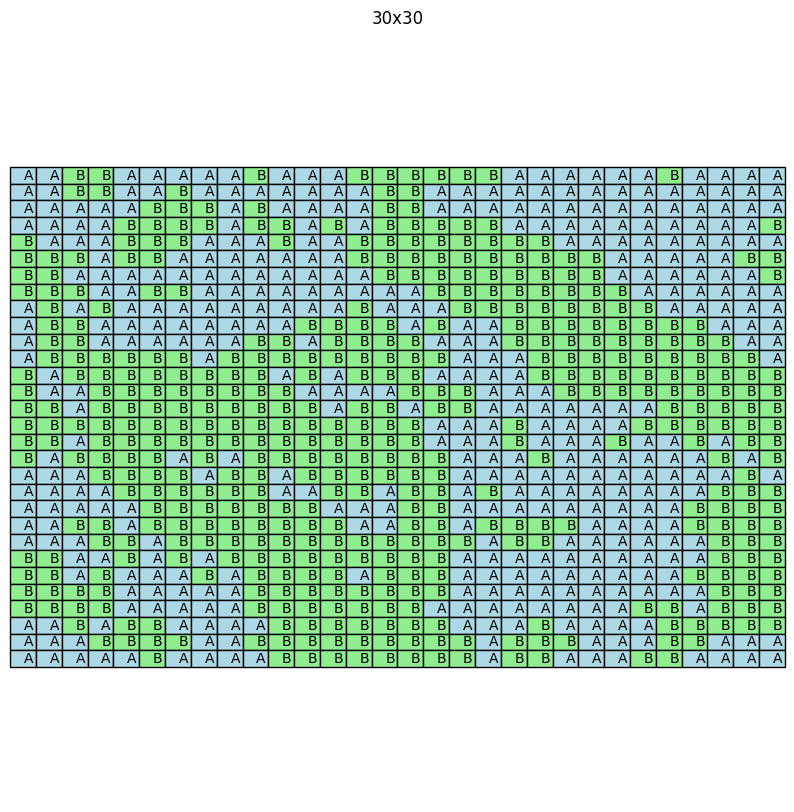


---------------------------Episode (8)---------------------------


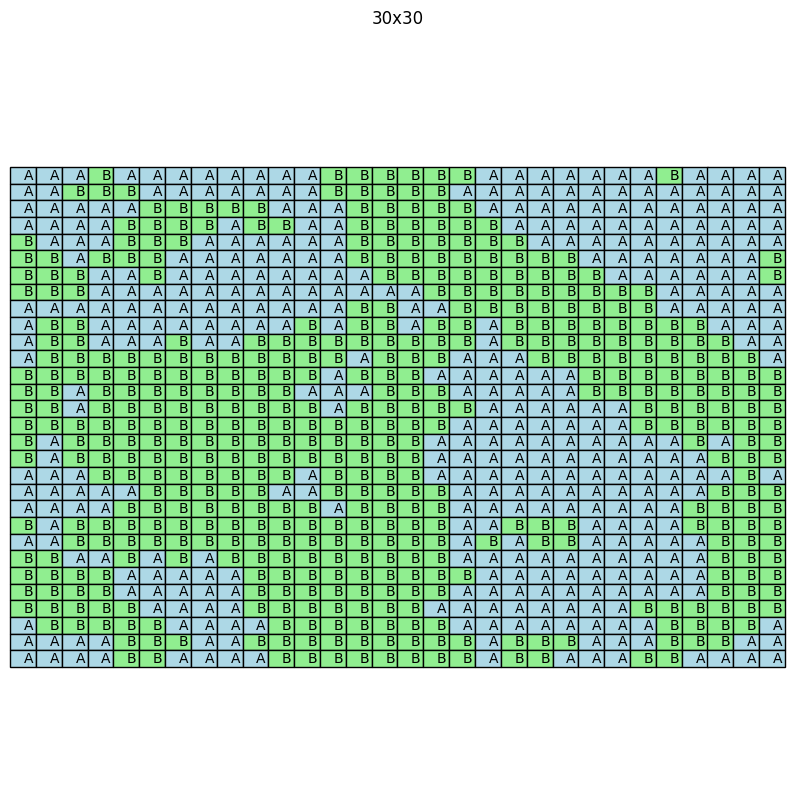


---------------------------Episode (16)---------------------------


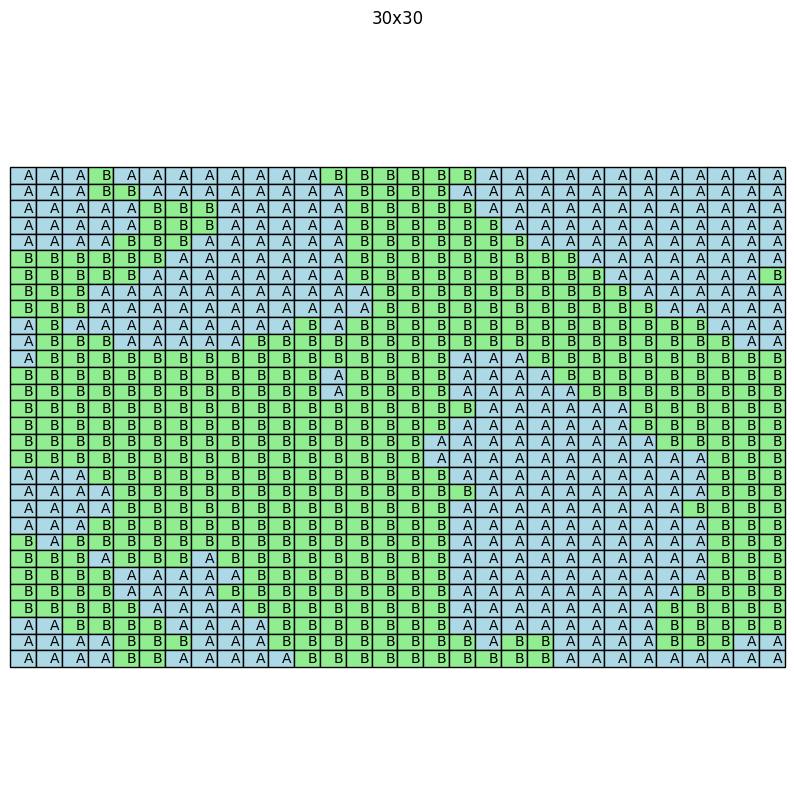


---------------------------Episode (32)---------------------------


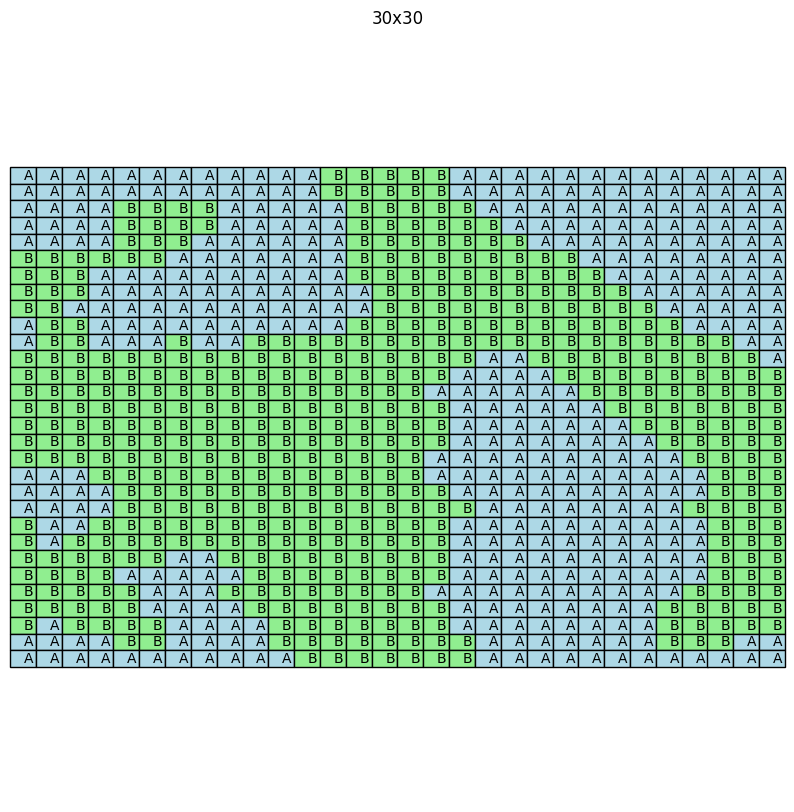


---------------------------Episode (64)---------------------------


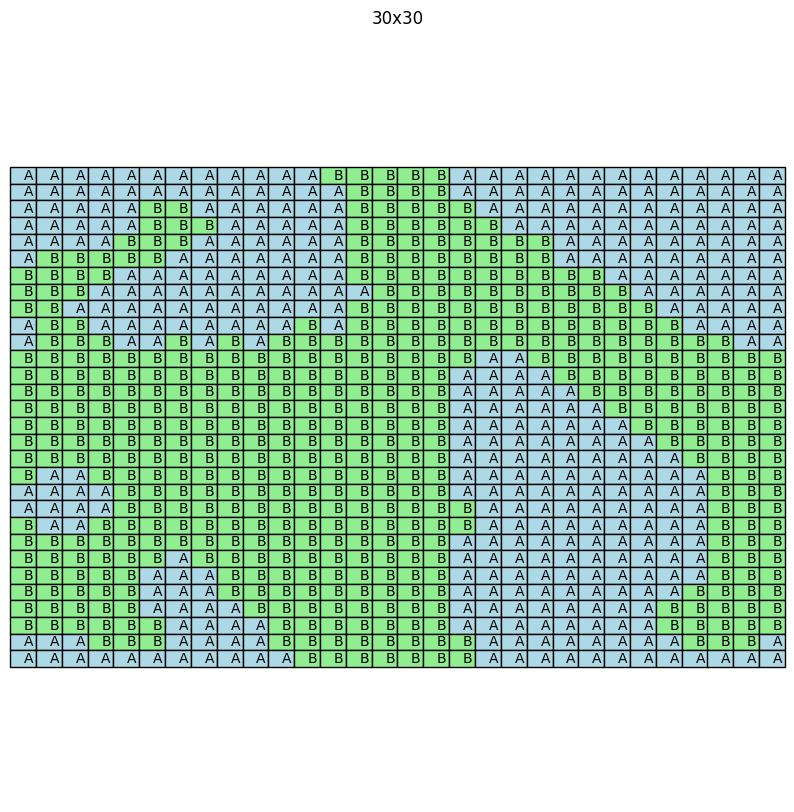


---------------------------Episode (128)---------------------------


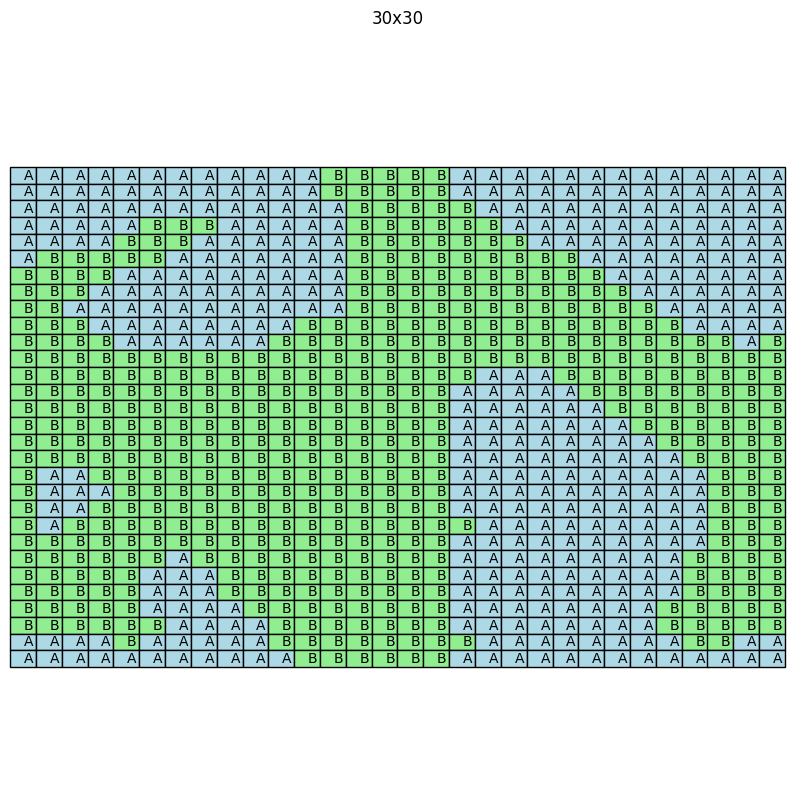


---------------------------Episode (256)---------------------------


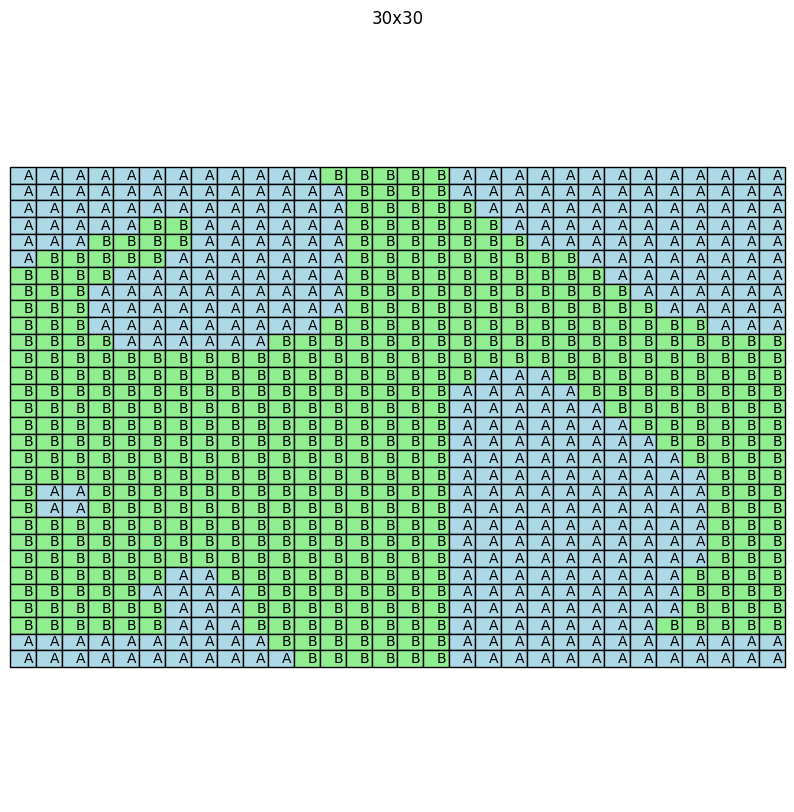


---------------------------Episode (512)---------------------------


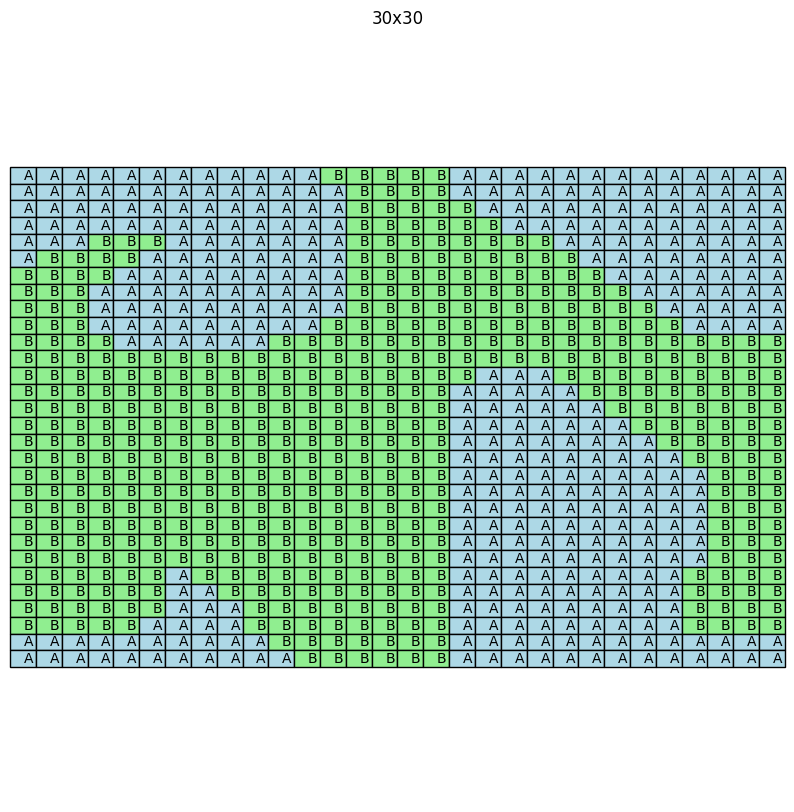


---------------------------Episode (1024)---------------------------


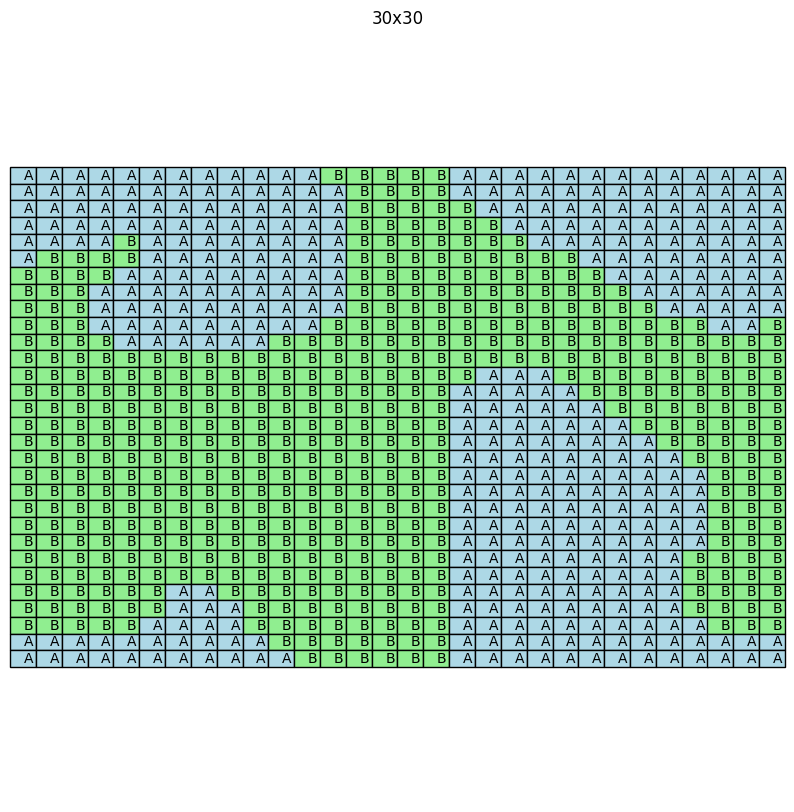

Terminating Loop: no change after 100 iterations.

Final Actions - Episode (1274):



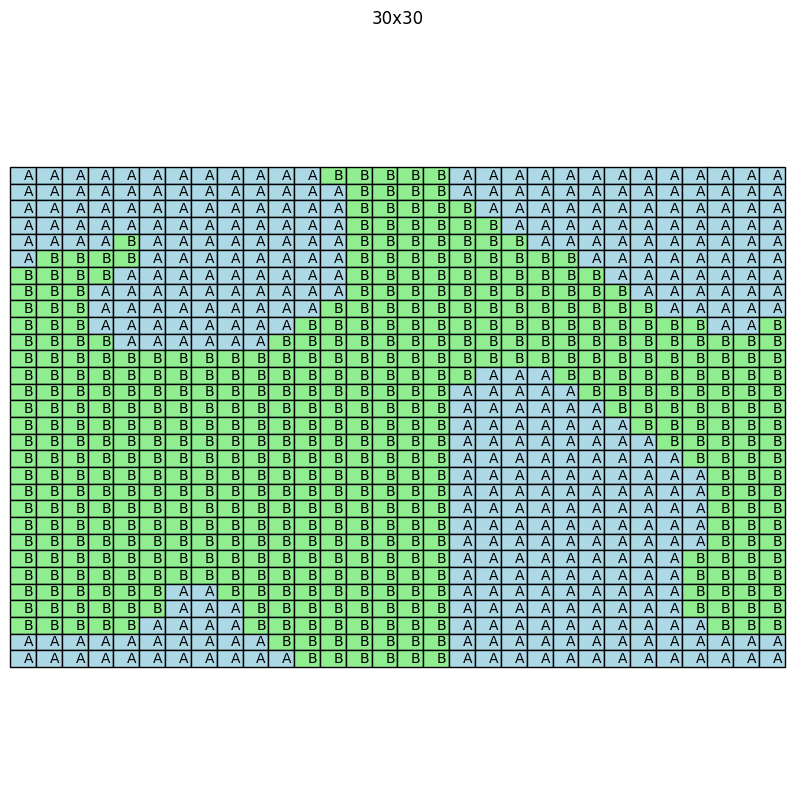

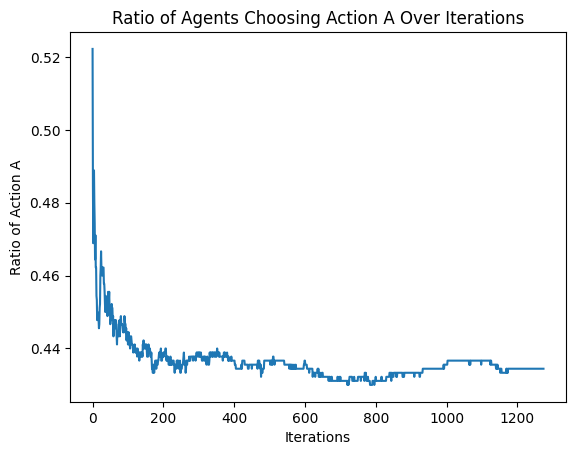

False

In [22]:
# Parameters: grid_size = N value, learning_algorithm = {'fp' = fictitious play, 'rl' = reinforcement learning}
# n_iter = number of episodes, iter_limit = terminate after no change experienced after iter_limit number of episodes

grid_env1 = Env(grid_size=30, seed=1854088, verbose=False)
c1 = coordinate(grid_env1)
c1.run(n_iter=5000, iter_limit=100, learning_algorithm='fp', verbose=True)

## Seed Search

## The following codes are used for experimentation, to find a good random initialization value, in order to obtain faster convergence to a single strategy. A set of random seeds are assessed with the pipeline and the first seed that converges within a preset time threshold is returned.

In [10]:
def pipeline(result_queue):
    grid_env1 = Env(grid_size=10, seed=seed, verbose=False)
    c1 = coordinate(grid_env1, learning_rate=0.01, gamma=0.1)
    append_logic = c1.run(n_iter=2500, iter_limit=2000, learning_algorithm='rl')
    result_queue.put(c1.actions)  # Put the actions in the queue


starting seed:  5376939
--------------Executing Reinforcement Learning Adaptation Process--------------


Actions (Randomly Initialized): 



<ipython-input-5-efb746378c6c>:5: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(self.seed)


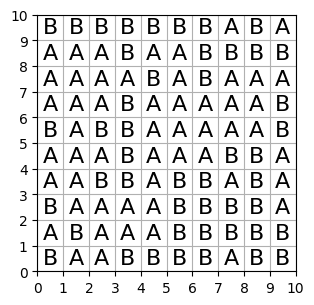


Final Actions:


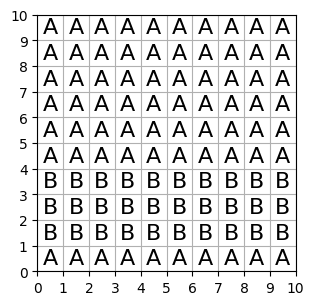

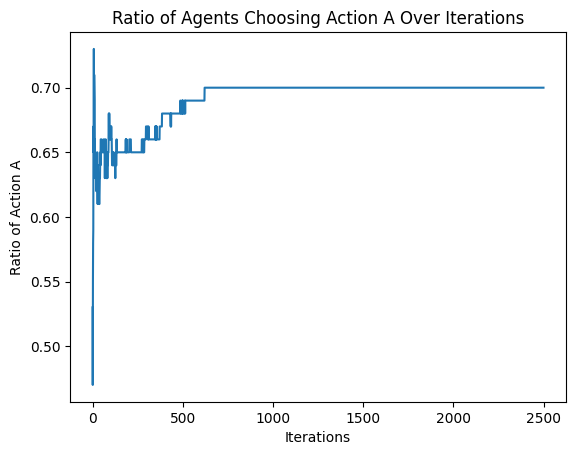


starting seed:  7976147
--------------Executing Reinforcement Learning Adaptation Process--------------


Actions (Randomly Initialized): 



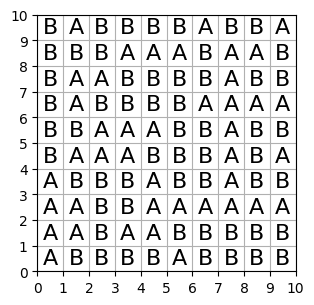


Final Actions:


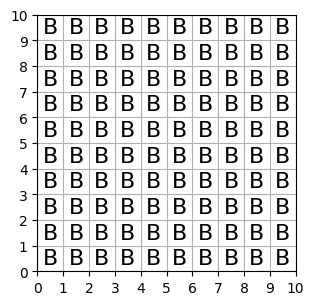

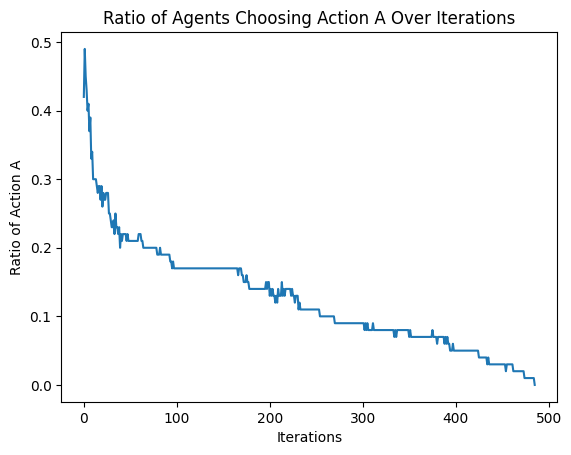

total Runtime: 3.929440498352051
Seed Value: 7976147


In [11]:
run_time = []
used_seed = []

test_seed = np.arange(0, 10000000)
seed_iter = 0
num_iter_limit = 500

while seed_iter < num_iter_limit:
    seed = np.random.choice(test_seed)
    print("\nstarting seed: ", seed)
    start_time = time.time()
    result_queue = Queue()
    my_thread = threading.Thread(target=pipeline, args=(result_queue,))
    my_thread.start()
    my_thread.join(timeout=80)
    if my_thread.is_alive():
        try:
            my_thread._stop()  # Terminate the thread
        except:
            print("\nExecution time exceeded the maximum allowed time.\n")
    else:
        end_time = time.time()
        total_runtime = end_time - start_time

        c1_actions = result_queue.get()  # Get the actions from the queue
        flattened_list = [e for r in c1_actions for e in r]
        # count of A and B actions
        A_cnt = Counter(flattened_list)['A']
        B_cnt = Counter(flattened_list)['B']
        # ratio of agents choosing action A
        A_cnt_ratio = A_cnt / (A_cnt + B_cnt)

        if A_cnt_ratio == 0 or A_cnt_ratio == 1:
            run_time.append(total_runtime)
            print("total Runtime:", total_runtime)
            used_seed.append(seed)
            print("Seed Value:", seed)

    seed_iter += 1

    if len(used_seed) >= 1:
        break